In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
import warnings

In [3]:
df = pd.read_csv("laptop_price_data.csv")

In [4]:
df = df.drop_duplicates()
df.shape

(802, 19)

In [5]:
df = df.drop(['Number of Ratings', 'Number of Reviews'], axis=1)
df.shape

(802, 17)

## Preparing X and y variables

In [6]:
X = df.drop(columns=['Price'], axis=1)
X

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,rating
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,2 stars
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,3 stars
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,3 stars
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,3 stars
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,3 stars
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,ASUS,AMD,Ryzen 9,Not Available,4 GB,DDR4,1024 GB,0 GB,Windows,64-bit,0 GB,Casual,1 year,No,No,3 stars
819,ASUS,AMD,Ryzen 9,Not Available,4 GB,DDR4,1024 GB,0 GB,Windows,64-bit,0 GB,Casual,1 year,No,No,3 stars
820,ASUS,AMD,Ryzen 9,Not Available,4 GB,DDR4,1024 GB,0 GB,Windows,64-bit,4 GB,Casual,1 year,No,No,3 stars
821,ASUS,AMD,Ryzen 9,Not Available,4 GB,DDR4,1024 GB,0 GB,Windows,64-bit,4 GB,Casual,1 year,No,No,3 stars


In [11]:
for c in X.columns:
    print(f"{c} : {list(X[c].unique())}")

brand : ['ASUS', 'Lenovo', 'acer', 'Avita', 'HP', 'DELL', 'MSI', 'APPLE']
processor_brand : ['Intel', 'AMD', 'M1']
processor_name : ['Core i3', 'Core i5', 'Celeron Dual', 'Ryzen 5', 'Core i7', 'Core i9', 'M1', 'Pentium Quad', 'Ryzen 3', 'Ryzen 7', 'Ryzen 9']
processor_gnrtn : ['10th', 'Not Available', '11th', '7th', '8th', '9th', '4th', '12th']
ram_gb : ['4 GB', '8 GB', '16 GB', '32 GB']
ram_type : ['DDR4', 'LPDDR4', 'LPDDR4X', 'DDR5', 'DDR3', 'LPDDR3']
ssd : ['0 GB', '512 GB', '256 GB', '128 GB', '1024 GB', '2048 GB', '3072 GB']
hdd : ['1024 GB', '0 GB', '512 GB', '2048 GB']
os : ['Windows', 'DOS', 'Mac']
os_bit : ['64-bit', '32-bit']
graphic_card_gb : ['0 GB', '2 GB', '4 GB', '6 GB', '8 GB']
weight : ['Casual', 'ThinNlight', 'Gaming']
warranty : ['No warranty', '1 year', '2 years', '3 years']
Touchscreen : ['No', 'Yes']
msoffice : ['No', 'Yes']
rating : ['2 stars', '3 stars', '4 stars', '5 stars', '1 star']


In [7]:
y = df['Price']

Transform to dollars

In [8]:
exchange_rate = 0.012  # 19/05/2023

y = y * exchange_rate

In [9]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

In [13]:
list(cat_features.values)

['brand',
 'processor_brand',
 'processor_name',
 'processor_gnrtn',
 'ram_gb',
 'ram_type',
 'ssd',
 'hdd',
 'os',
 'os_bit',
 'graphic_card_gb',
 'weight',
 'warranty',
 'Touchscreen',
 'msoffice',
 'rating']

There are no numerical variables

In [14]:
cat_pipeline = Pipeline(
            steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("one_hot_encoder", OneHotEncoder()),
            ("scaler", StandardScaler(with_mean=False))
            ]
        )

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
print(X_train.shape)
print(X_test.shape)

(641, 16)
(161, 16)


In [63]:
X_train = cat_pipeline.fit_transform(X_train)
X_test = cat_pipeline.transform(X_test)

In [64]:
X_train.shape

(641, 77)

In [23]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [22]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'K-Neighbors Regressor': KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    'xgboost' : XGBRegressor(),
    'Lightgbm' : LGBMRegressor(),
    'Gradient boosting' : GradientBoostingRegressor(),
    'support vector': SVR(),
    'AdaBoost Regressor': AdaBoostRegressor()
}

In [24]:
model_list = []
metric_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    metric_list.append({
        'mae': model_test_mae,
        'rmse': model_test_rmse,
        'r2_score': model_test_r2
    })
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 201.6101
- Mean Absolute Error: 129.9764
- R2 Score: 0.8601
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 371.8797
- Mean Absolute Error: 192.1375
- R2 Score: 0.5485


Ridge
Model performance for Training set
- Root Mean Squared Error: 201.6310
- Mean Absolute Error: 130.0099
- R2 Score: 0.8600
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 370.8908
- Mean Absolute Error: 191.6681
- R2 Score: 0.5509


Lasso
Model performance for Training set
- Root Mean Squared Error: 202.2807
- Mean Absolute Error: 129.4004
- R2 Score: 0.8591
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 366.6944
- Mean Absolute Error: 187.6600
- R2 Score: 0.5610


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 230.2185
- Mean Absolute Error: 120.8044
- R2 Score: 0.

In [85]:
sorted_results = sorted(results.values(), key=lambda x: x['r2_score'], reverse=True)[0]['r2_score']
sorted_results

0.92

In [90]:
best_model = max(results, key=lambda x: results[x]['r2_score'])
best_r2_score = results[best_model]['r2_score']

In [91]:
best_r2_score

0.92

In [76]:
results = {
    'model1': {'r2_score': 0.89, 'mae': 235.3},
    'model2': {'r2_score': 0.92, 'mae': 210.8},
    'model3': {'r2_score': 0.87, 'mae': 245.1}
}

sorted_results = max(sorted(results.items(), key=lambda x: x[1]['r2_score'], reverse=True))[1]['r2_score']
sorted_results

0.87

In [30]:
import pandas as pd

data = []

for model, metrics in zip(model_list, metric_list):
    row = [model, metrics['mae'], metrics['rmse'], metrics['r2_score']]
    data.append(row)

df = pd.DataFrame(data, columns=['model_name', 'mae', 'rmse', 'r2_score']).sort_values(by=["r2_score"],ascending=False)

print(df)

                 model_name         mae        rmse  r2_score
7                  Lightgbm  154.693517  277.015452  0.749491
5   Random Forest Regressor  162.929459  310.918904  0.684420
8         Gradient boosting  165.720786  311.202026  0.683845
6                   xgboost  173.337036  348.608017  0.603275
3     K-Neighbors Regressor  176.573411  357.125394  0.583652
4             Decision Tree  190.417441  360.436548  0.575895
2                     Lasso  187.659981  366.694434  0.561041
1                     Ridge  191.668074  370.890756  0.550937
0         Linear Regression  192.137460  371.879674  0.548539
10       AdaBoost Regressor  346.442271  413.918715  0.440699
9            support vector  366.561777  577.137886 -0.087363


In [31]:
lgbm_model = LGBMRegressor()
lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 74.95


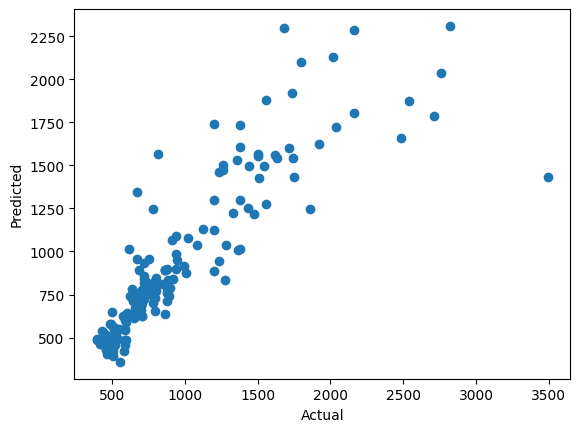

In [34]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

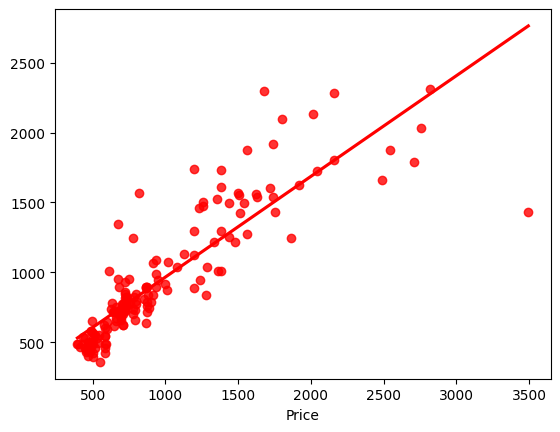

In [33]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [35]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
196,611.880,1011.795532,-399.915532
299,875.880,898.222636,-22.342636
171,497.880,650.294000,-152.414000
537,1736.280,1919.765174,-183.485174
551,1559.880,1275.290996,284.589004
...,...,...,...
368,1379.880,1298.256479,81.623521
361,1512.000,1427.591341,84.408659
446,695.880,700.348852,-4.468852
767,1283.880,1039.385759,244.494241
